# XGBoost High Depth
As part of the overall stacking model, I will develop four gradient boosting models (GBMs): one low depth and one high depth GBM each using LightGBM and XGBoost.
  
In this notebook, I set out to optimise the high depth XGBoost model. The optimisation sequence was as follows:  
  
1. No. of Trees (100)
2. RFECV (22)
3. Max Features (0.2727272727272727 or 6)
4. Subsampling (0.3)
5. Learning Rate (0.1)
6. Min Child Weight (0.3)
7. L2 Regularisation (0.1)
8. L1 Regularisation (0.9)
  
The final CV score was **83.70%**.

In [1]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
from xgboost import XGBClassifier
import kaggle_titanic as kt
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Prepare Data

In [2]:
# Import data
df = pd.read_csv('train.csv')

# Clean data
df = kt.clean_all(df)

# Encode data (only for RFECV purposes)
df_encoded, _ = kt.encode_train(df)

## Global Settings

In [3]:
# Create fold indices
folds = kt.get_folds(df=df, random_state=123)

# Get all datasets
all_sets = kt.prep_sets(df, folds)

## Iteration 1: Optimise No. of Trees

Computing test scores for n_estimators = 100...Done!
Computing test scores for n_estimators = 250...Done!
Computing test scores for n_estimators = 500...Done!
Computing test scores for n_estimators = 1000...Done!
Computing test scores for n_estimators = 1500...Done!
Computing test scores for n_estimators = 2000...Done!
Computing test scores for n_estimators = 2500...Done!
Computing test scores for n_estimators = 3000...Done!
Computing test scores for n_estimators = 4000...Done!
Computing test scores for n_estimators = 5000...Done!


[ RESULTS ]
   Best Score: 0.8101100898755828
Optimal Value: 100


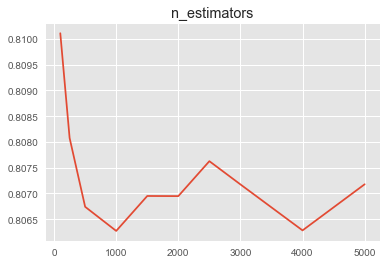

In [4]:
# Define parameters
param_n_estimators = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
params = {
    'n_estimators': param_n_estimators
}

# Grid Search with CV
cv_res, best_n_estimators = kt.score_grid(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        # n_estimators = ,
        # colsample_bytree = ,
        # subsample = ,
        # learning_rate = ,
        # min_child_weight = ,
        # reg_lambda = ,
        # reg_alpha = 
    ),
    params = params,
    all_sets = all_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 2: RFECV for Feature Selection

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  8.0min finished


   Best Score: 0.8154845170929577
Optimal Value: 22


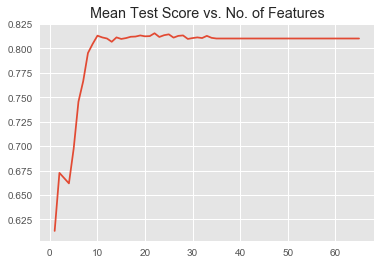

In [5]:
# Run RFECV
cv_res, best_n_features, opt_feats = kt.custom_rfecv(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        n_estimators = best_n_estimators,
        # colsample_bytree = ,
        # subsample = ,
        # learning_rate = ,
        # min_child_weight = ,
        # reg_lambda = ,
        # reg_alpha = 
    ),
    sub_sets = all_sets,
    df = df_encoded,
    step = 1,
    n_jobs = 3,
    xg = True,
    verbose = True
)

### Subset Features

In [6]:
# Separate features
final_feats = list(opt_feats)
print(final_feats)

['pclass_OC', 'sex_BN', 'age_OC', 'age_NM', 'sibsp_NM', 'parch_NM', 'fare_NM', 'title_ME', 'age_ME', 'sibsp_ME', 'ticlen_ME', 'fare_ME', 'cabletter_ME', 'cabno_ME', 'embarked_ME', 'pclass_OH_CLASS2', 'age_OH_A4', 'age_OH_A5', 'ticlen_OH_L4', 'ticlen_OH_L6', 'fare_OH_G2', 'fare_OH_G4']


In [7]:
# Re-generate sets
new_sets = kt.prep_sets(df = df, folds = folds, feats = final_feats)

## Iteration 3: Tune Maximum Features

In [8]:
# Get max features
n_feat = np.min([new_sets[i][0].shape[1] for i in range(len(new_sets))])

Computing test scores for colsample_bytree = 0.09090909090909091...Done!
Computing test scores for colsample_bytree = 0.13636363636363635...Done!
Computing test scores for colsample_bytree = 0.1818181818181818...Done!
Computing test scores for colsample_bytree = 0.22727272727272724...Done!
Computing test scores for colsample_bytree = 0.2727272727272727...Done!
Computing test scores for colsample_bytree = 0.3181818181818181...Done!
Computing test scores for colsample_bytree = 0.36363636363636354...Done!
Computing test scores for colsample_bytree = 0.40909090909090906...Done!
Computing test scores for colsample_bytree = 0.4545454545454545...Done!
Computing test scores for colsample_bytree = 0.4999999999999999...Done!
Computing test scores for colsample_bytree = 0.5454545454545453...Done!
Computing test scores for colsample_bytree = 0.5909090909090908...Done!
Computing test scores for colsample_bytree = 0.6363636363636362...Done!
Computing test scores for colsample_bytree = 0.681818181818

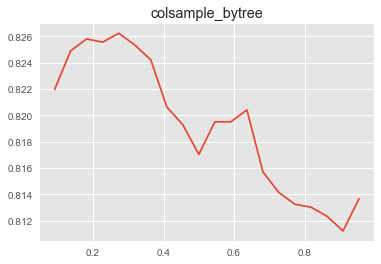

In [9]:
# Define parameters
param_max_feat = np.arange(2/n_feat, 1, 1/n_feat)
params = {
    'colsample_bytree': param_max_feat
}

# Grid Search with CV
cv_res, best_colsample_bytree = kt.score_grid(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        n_estimators = best_n_estimators,
        # colsample_bytree = ,
        # subsample = ,
        # learning_rate = ,
        # min_child_weight = ,
        # reg_lambda = ,
        # reg_alpha = 
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

In [10]:
# best_colsample_bytree = 0.8333333333333335
print(best_colsample_bytree)

0.2727272727272727


## Iteration 4: Tune Subsampling Proportion

Computing test scores for subsample = 0.3...Done!
Computing test scores for subsample = 0.4...Done!
Computing test scores for subsample = 0.5...Done!
Computing test scores for subsample = 0.6...Done!
Computing test scores for subsample = 0.7...Done!
Computing test scores for subsample = 0.8...Done!
Computing test scores for subsample = 0.9...Done!
Computing test scores for subsample = 0.99...Done!


[ RESULTS ]
   Best Score: 0.8365833163994302
Optimal Value: 0.3


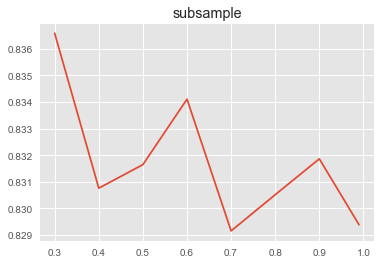

In [11]:
# Define parameters
param_subsample = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
params = {
    'subsample': param_subsample
}

# Grid Search with CV
cv_res, best_subsample = kt.score_grid(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        # subsample = ,
        # learning_rate = ,
        # min_child_weight = ,
        # reg_lambda = ,
        # reg_alpha = 
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

In [12]:
# Override
# best_subsample = 0.6

## Iteration 5: Tune Learning Rate

Computing test scores for learning_rate = 0.001...Done!
Computing test scores for learning_rate = 0.005...Done!
Computing test scores for learning_rate = 0.01...Done!
Computing test scores for learning_rate = 0.05...Done!
Computing test scores for learning_rate = 0.1...Done!
Computing test scores for learning_rate = 0.2...Done!
Computing test scores for learning_rate = 0.3...Done!


[ RESULTS ]
   Best Score: 0.8365833163994302
Optimal Value: 0.1


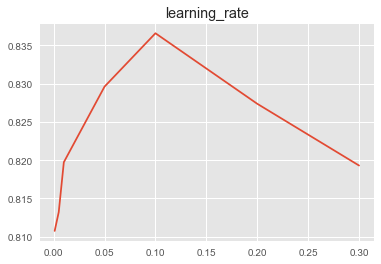

In [13]:
# Define parameters
param_learning_rate = [0.001,0.005,0.01,0.05,0.1,0.2,0.3]
params = {
    'learning_rate': param_learning_rate
}

# Grid Search with CV
cv_res, best_learn_rate = kt.score_grid(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        subsample = best_subsample,
        # learning_rate = ,
        # min_child_weight = ,
        # reg_lambda = ,
        # reg_alpha = 
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 6: Tune Min. Child Weight

Computing test scores for min_child_weight = 0.001...Done!
Computing test scores for min_child_weight = 0.005...Done!
Computing test scores for min_child_weight = 0.01...Done!
Computing test scores for min_child_weight = 0.05...Done!
Computing test scores for min_child_weight = 0.1...Done!
Computing test scores for min_child_weight = 0.2...Done!
Computing test scores for min_child_weight = 0.3...Done!


[ RESULTS ]
   Best Score: 0.8363623777256934
Optimal Value: 0.3


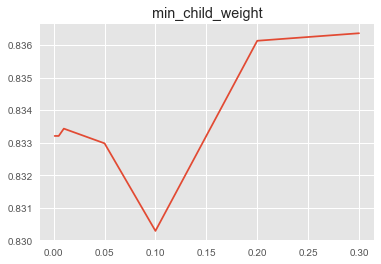

In [14]:
# Define parameters
param_min_child_weight = [0.001,0.005,0.01,0.05,0.1,0.2,0.3]
params = {
    'min_child_weight': param_min_child_weight
}

# Grid Search with CV
cv_res, best_min_child = kt.score_grid(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        subsample = best_subsample,
        learning_rate = best_learn_rate,
        # min_child_weight = ,
        # reg_lambda = ,
        # reg_alpha = 
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 7: Tune L2 Regularisation (Lambda)

Computing test scores for reg_lambda = 0...Done!
Computing test scores for reg_lambda = 0.1...Done!
Computing test scores for reg_lambda = 0.2...Done!
Computing test scores for reg_lambda = 0.3...Done!
Computing test scores for reg_lambda = 0.4...Done!
Computing test scores for reg_lambda = 0.5...Done!
Computing test scores for reg_lambda = 0.6...Done!
Computing test scores for reg_lambda = 0.7...Done!
Computing test scores for reg_lambda = 0.8...Done!
Computing test scores for reg_lambda = 0.9...Done!


[ RESULTS ]
   Best Score: 0.836133878197183
Optimal Value: 0.9


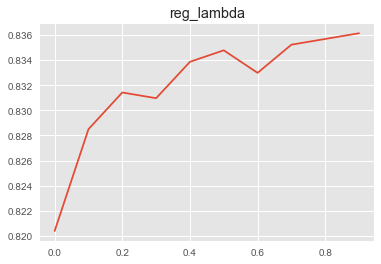

In [15]:
# Define parameters
param_lambda = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_lambda': param_lambda
}

# Grid Search with CV
cv_res, best_lambda = kt.score_grid(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        subsample = best_subsample,
        learning_rate = best_learn_rate,
        min_child_weight = best_min_child,
        # reg_lambda = ,
        # reg_alpha = 
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

## Iteration 8: Tune L1 Regularisation (Alpha)

Computing test scores for reg_alpha = 0...Done!
Computing test scores for reg_alpha = 0.1...Done!
Computing test scores for reg_alpha = 0.2...Done!
Computing test scores for reg_alpha = 0.3...Done!
Computing test scores for reg_alpha = 0.4...Done!
Computing test scores for reg_alpha = 0.5...Done!
Computing test scores for reg_alpha = 0.6...Done!
Computing test scores for reg_alpha = 0.7...Done!
Computing test scores for reg_alpha = 0.8...Done!
Computing test scores for reg_alpha = 0.9...Done!


[ RESULTS ]
   Best Score: 0.8370390884134156
Optimal Value: 0.1


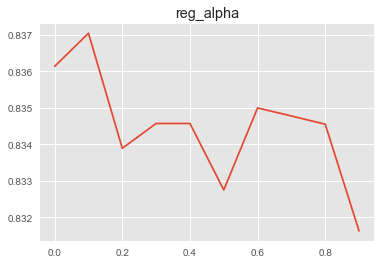

In [16]:
# Define parameters
param_alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_alpha': param_alpha
}

# Grid Search with CV
cv_res, best_alpha = kt.score_grid(
    estimator = XGBClassifier(
        booster = 'gbtree',
        # objective = 'binary',
        random_state = 123,
        n_jobs = 3,
        max_depth = 15,
        n_estimators = best_n_estimators,
        colsample_bytree = best_colsample_bytree,
        subsample = best_subsample,
        learning_rate = best_learn_rate,
        min_child_weight = best_min_child,
        reg_lambda = best_lambda,
        # reg_alpha = 
    ),
    params = params,
    all_sets = new_sets,
    n_jobs = 3,
    verbose = True
)

In [17]:
# Print
print('Trees: ' + str(best_n_estimators))
print('Features: ' + str(len(final_feats)))
print('Feature Proportions: ' + str(best_colsample_bytree))
print('Subsample: ' + str(best_subsample))
print('Learning Rate: ' + str(best_learn_rate))
print('Min Child Weight: ' + str(best_min_child))
print('Alpha: ' + str(best_alpha))
print('Lambda: ' + str(best_lambda))

Trees: 100
Features: 22
Feature Proportions: 0.2727272727272727
Subsample: 0.3
Learning Rate: 0.1
Min Child Weight: 0.3
Alpha: 0.1
Lambda: 0.9
